# <center>2. Down Sampling </center>


### PortPy provides pre-computed data with pre-defined resolutions. This example demonstrates the following down-sampling processes:


 1. Creating a plan using the original data resolution
 2.  Down-sampling beamlets
 3. Calculating the plan quality cost associated with beamlet down-sampling
 4. Down-sampling the voxels
 5. Calculating the plan quality cost associated with voxel down-sampling

### 1) Creating a plan using the original data resolution
 Note: you first need to download the patient database from the link provided in the GitHub page.


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# provide data directory and patient id
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Patient_7'
data.patient_id = patient_id

In [4]:
# Load ct, structure and beams as an object
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)

# create extra optimization structures based upon structure definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

# ### Run Optimization
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_orig = opt.solve(solver='MOSEK', verbose=False)


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done


### 2) Creating a plan using down-sampled beamlets 

In [5]:
# Note: PortPy only allows down-sampling beamlets as a factor of original finest beamlet resolution
#   e.g if the finest beamlet resolution is 2.5mm (often the case) then down sampled beamlet can be 5, 7.5, 10mm
# Down sample beamlets by a factor of 4
beamlet_down_sample_factor = 4
# Calculate the new beamlet resolution
print('Finest beamlet width is {} mm and height is {} mm'.format(beams.get_finest_beamlet_width(),
                                                                 beams.get_finest_beamlet_height()))

print('Data beamlet width is {} mm and height is {} mm'.format(beams.get_beamlet_width(),
                                                               beams.get_beamlet_height()))
new_beamlet_width_mm = my_plan.beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = my_plan.beams.get_finest_beamlet_height() * beamlet_down_sample_factor

print('Down sampling beamlet width is {} mm and height is {} mm'.format(new_beamlet_width_mm,
                                                               new_beamlet_height_mm))

# Calculate the new beamlet resolution
inf_matrix_db = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                              beamlet_height_mm=new_beamlet_height_mm)

# running optimization using downsampled beamlets
# create cvxpy problem with max and mean dose clinical criteria and the above objective functions
opt = pp.Optimization(my_plan, opt_params=opt_params,
                      inf_matrix=inf_matrix_db)
opt.create_cvxpy_problem()
sol_db = opt.solve(solver='MOSEK', verbose=False)


Finest beamlet width is 2.5 mm and height is 2.5 mm
Data beamlet width is 2.5 mm and height is 5.0 mm
Down sampling beamlet width is 10.0 mm and height is 10.0 mm
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
Objective Start
Objective done
Constraints Start
Constraints done


### 3) Cost of Down-sampling beamlets

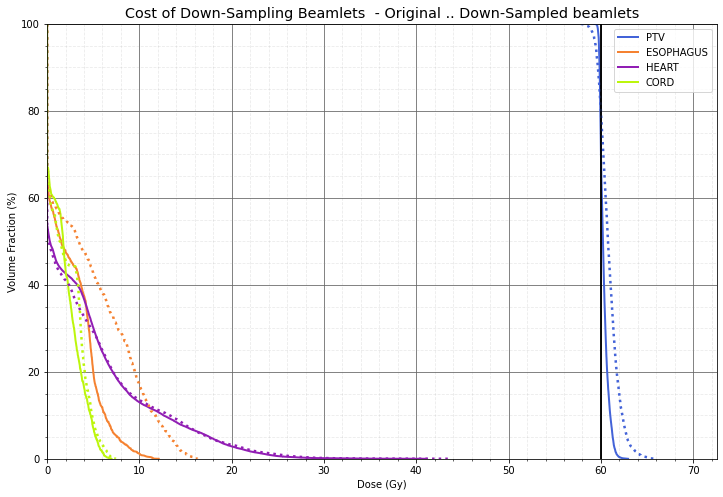

In [6]:
# To know the cost of down sampling beamlets, lets compare the dvh of down sampled beamlets with original
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_orig, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_db, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('Cost of Down-Sampling Beamlets  - Original .. Down-Sampled beamlets')
plt.show()


### 4) Creating plan using down-sampled voxels 

In [12]:
# Note: PortPy only allows down-sampling voxels as a factor of ct voxel resolutions resolution
# PortPy can down-sample optimization voxels as factor of ct voxels.
# Down sample voxels by a factor of 5 in x, y and 1 in z direction
voxel_down_sample_factors = [5, 5, 1]

# Calculate the new voxel resolution
print('CT voxel resolution in xyz is {} mm'.format(ct.get_ct_res_xyz_mm()))
print('Data optimization voxel resolution in xyz is {} mm'.format(structs.opt_voxels_dict['dose_voxel_resolution_xyz_mm']))
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
print('Down Sampled optimization voxel resolution in xyz is {} mm'.format(opt_vox_xyz_res_mm))
inf_matrix_dv = inf_matrix.create_down_sample(opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# running optimization using down sampled voxels
opt = pp.Optimization(my_plan, opt_params=opt_params, inf_matrix=inf_matrix_dv)
opt.create_cvxpy_problem()
sol_dv = opt.solve(solver='MOSEK', verbose=False)


CT voxel resolution in xyz is [0.98, 0.98, 3] mm
Data optimization voxel resolution in xyz is [2.93, 2.93, 3] mm
Down Sampled optimization voxel resolution in xyz is [4.9, 4.9, 3] mm
reindexing voxels...
creating influence matrix for down sample voxels..
Objective Start
Objective done
Constraints Start
Constraints done


### 5) Cost and discrepancy of Down-sampling voxels 

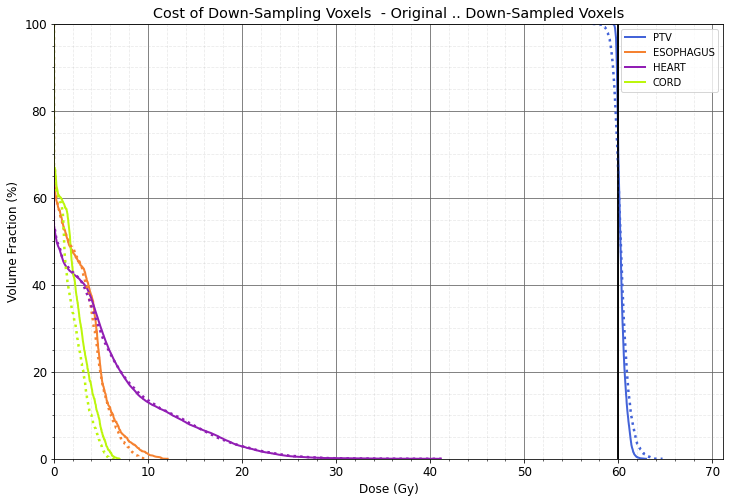

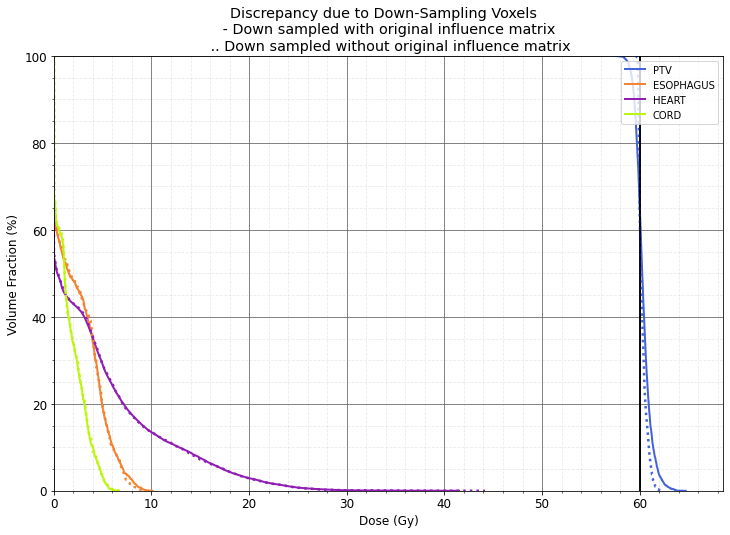

In [13]:
# Similarly to analyze the cost of down sampling voxels, lets compare the dvh of down sampled voxels with original
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
sol_dv_new = inf_matrix_dv.sol_change_inf_matrix(sol_dv, inf_matrix=sol_orig['inf_matrix'])
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_orig, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_dv_new, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('Cost of Down-Sampling Voxels  - Original .. Down-Sampled Voxels')
plt.show()

# To get the discrepancy due to down sampling voxels
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_dv_new, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_dv, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title(
    'Discrepancy due to Down-Sampling Voxels  \n - Down sampled with original influence matrix \n .. Down sampled without original influence matrix')
plt.show()
